<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Differential-Ranking-Analysis" data-toc-modified-id="Differential-Ranking-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Differential Ranking Analysis</a></span></li><li><span><a href="#Gaussian-mixture-modeling" data-toc-modified-id="Gaussian-mixture-modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Gaussian mixture modeling</a></span></li><li><span><a href="#Comparative-Genomics-Analysis" data-toc-modified-id="Comparative-Genomics-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparative Genomics Analysis</a></span><ul class="toc-item"><li><span><a href="#Whole-genome-shotgun-sequencing-genome-analysis" data-toc-modified-id="Whole-genome-shotgun-sequencing-genome-analysis-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Whole genome shotgun sequencing genome analysis</a></span></li><li><span><a href="#Human-genome-RNAseq-pathway-aggregation" data-toc-modified-id="Human-genome-RNAseq-pathway-aggregation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Human genome RNAseq pathway aggregation</a></span></li><li><span><a href="#Overlap-across-omics-layers" data-toc-modified-id="Overlap-across-omics-layers-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Overlap across omics layers</a></span></li></ul></li><li><span><a href="#Save-compounds" data-toc-modified-id="Save-compounds-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save compounds</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

# Differential Ranking Analysis

Differential abundance analysis seeks to detect differentially abundant omic features (species, OTUs, metabolites, cytokines,...) between two conditions. While such an analysis can improve our understanding of the aetiology of a disease and potentially lead to preventive or therapeutic strategies, the compositional nature of omics data, and in particular microbiome data, poses unique challenges for performing traditional differential abundance analysis.

First, and because no absolute microbial abundances can be determined at the time of sampling (concentrations, cells/gram, ...), it is not possible to determine absolute changes in microbial abundances. Instead, one is limited to determine relative abundances and then use log-fold change up to a constant bias to ‘sort’ microbes, or any other omics feature characterized by the same sampling limitations to show relative degrees of ‘perturbation’ across all features present in an omic dataset (see [this paper](https://www.nature.com/articles/s41467-019-10656-5) on a full explanation).  

The second major challenge is dealing with batch effects. Due to differences in collection and processing protocols, different studies are no longer directly comparable. Adopting an approach that zeroes out such batch effects by making the differential analysis study-specific can help minimize any batch-related confounders in a combined analysis.

Due to these and other challenges, differential abundance analysis remains one of the more controversial approaches to analyzing microbiome datasets. 

Here, and in order to address these challenges by maximizing the amount of information we could extract from the datasets while minimizing any batch-related confounders, we designed a customized differential abundance tool that could leverage the experimental designs of each of the studies included in the analysis. Specifically, we incorporated age-sex matching into the statistical models to allow us to determine feature perturbation profiles within the context of each individual study followed by a combined analysis of the normalized perturbation profiles of different studies. The overall model had the following structure

$$
y_{i,j} \sim NegativeBinomial(\lambda_{i,j}, \alpha_j)\\
\log \lambda_{i,j} = \log N_i + C_{k(i), j} + \Delta_j \textrm{I}[i=ASD]
$$

Here $y_{i,j}$ denotes the microbial counts in sample $i$ and species $j$ and $\alpha_j$ represents the microbe specific over-dispersion term. The sequencing depth is represented by $N_i$. By incorporating $N_i$ into the model, the model is self-normalizing and doesn't need rarefaction.  $C_{k(i), j}$ represents the log proportion of microbe $j$ in the $k(i)$ control subject.  This is where the age-sex matching comes in; $k(i)$ denotes the pairing that sample i belongs to.
$\Delta_j$ represents microbe log-fold change difference between the control and ASD subject, the quantity that we are interested in.  For finishing touches, $\textrm{I}[i=ASD]$ a function that is 0 if sample i corresponds to the control subject and 1 is sample i corresponds to the ASD subject.

One advantage of using the above model is that if the batch effects are multiplicative (e.g., PCR amplification bias), they will cancel out and will not impact the calculation of $\Delta_j$. In addition, the above model structure provides a template for fitting a differential abundance model to different types of omics data.

The model was fitted using a Monte-Carlo Markov Chain (MCMC) approach. Because MCMC is a computationally very intensive method, we ran the model fittings shown here offline to make the notebook operational.

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0/differentials-v7.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v7.nc'
rna_fname = f'{rna_directory}/{posterior_name}/rna_differentials-v4.nc'
vir_fname = f'{wgs_directory}/{posterior_name}/viral_differentials-v4.nc'

amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)
rna_diffs = extract_differentials(rna_fname)
vir_diffs = extract_differentials(vir_fname)

# Gaussian mixture modeling

In [3]:
from util import solve, reorder, balance_thresholds
from plot import gaussian_mixture_plot
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn


# convert to clr coordinates
amp_clr_diffs = amp_diffs - amp_diffs.mean(axis=0)

gmod = GaussianMixture(n_components=3)
gmod.fit(X=amp_clr_diffs)


gm = np.sort(gmod.means_.mean(axis=1))

reference_frame = gm[1]  # set ANCOM-BC like delta

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_frame=reference_frame)
wgs_stats = ranking(wgs_diffs, reference_percentile=50)
rna_stats = ranking(rna_diffs, reference_percentile=50)
vir_stats = ranking(vir_diffs, reference_percentile=50)


amp_clr_diffs = amp_diffs - amp_diffs.mean(axis=0)
# sorts by distribution, namely, left, middle and right
pdfs = np.vstack(
    [mvn.pdf(amp_clr_diffs.values, mean=gmod.means_[i], cov=gmod.covariances_[i])
     for i in np.argsort(gmod.means_.mean(axis=1))]
).T
cluster_labels = np.argmax(pdfs, axis=1)

amp_stats['cluster_id'] = cluster_labels

def cluster_f(x):
    if x == 0:
        return 'denom'
    if x == 1:
        return 'neutral'
    if x == 2:
        return 'num'
    return None

amp_stats['cluster_name'] = amp_stats['cluster_id'].apply(cluster_f) 

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/_multivariate.py:528: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, mean, psd.U, psd.log_pdet, psd.rank))


One of the benefits of fitting these models in a Bayesian setting is that we were able to quantify the uncertainty surrounding the parameters of interest. This was crucial for us since we wanted to be able to quantify how well we could estimate the microbial log-changes between the control and ASD subjects. Doing so allowed us to compute Bayesian p values along with a full array of statistics. Here, we will focus on a one-sided T-test to identify the top 5% most differentially increased microbes. Specifically, we will use the following statistic

$$
t_j = \frac{\bar{\Delta_j} - \Delta_{95\%}}{s_j / M}
$$

We calculate this T-statistic using draws from the *posterior distribution* of $\Delta_j$, from which we can compute p-values. Here $\bar{\Delta_j}$ represents the average log-fold change for microbe $j$, $\Delta_{95\%}$ represents the expected log-fold for the $95\%$th most differentially increased microbe, $s_j$ represents the estimated standard deviation from $M$ posterior draws.  Computing this quantity will allow us to focus our attention to the top 5% most differentially increased microbes in ASD subjects.  And because we are in a Bayesian setting, we can easily compute these quantities by explicitly sampling from the *posterior distribution* of $\Delta_j$ (Please, refer to the Appendix for a detailed explanation of these concepts).

The reason why we should this approach rather than comparing against medians and averages as done in DESeq2 and Aldex2 is because these enforce extremely strong assumptions that typically do not hold in practice and yield extremely high false positive rates. By only investigating the top 5% most differentially abundant features, we adopt a much more conservative approach.

We applied this differential abundance approach to 16S amplicon data, metagenomic shotgun sequencing data and RNAseq data (we are in the process of applying the same approach to virome data and metabolome data as well). Plotted below are the log-fold change estimates across eight 16S amplicon datasets, four metagenomic datasets and four RNAseq datasets.

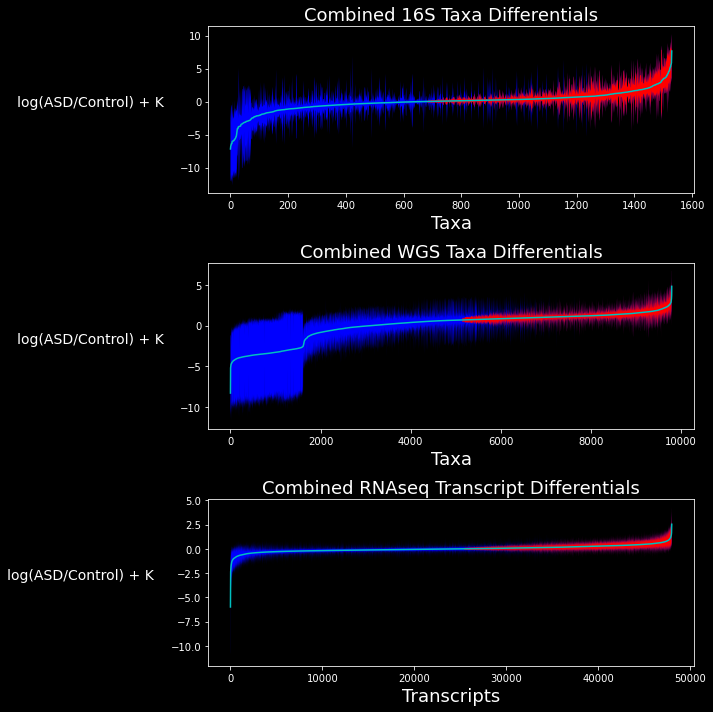

In [4]:
# Plot the log-fold changes
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    rankplot(amp_stats, ax[0])
    ax[0].set_title('Combined 16S Taxa Differentials', 
                    fontsize=18)
    ax[0].set_xlabel('Taxa', fontsize=18)
    rankplot(wgs_stats, ax[1])
    ax[1].set_title('Combined WGS Taxa Differentials', 
                    fontsize=18)
    ax[1].set_xlabel('Taxa', fontsize=18)
    rankplot(rna_stats, ax[2])
    ax[2].set_title('Combined RNAseq Transcript Differentials', 
                    fontsize=18)
    ax[2].set_xlabel('Transcripts', fontsize=18)
    plt.tight_layout()

There are two parts to each figure. We have plotted the 95% credible intervals for each microbe’s log-fold change estimate. Due to the unknown bias denoted by $K$, we cannot exactly identify where 0 is, motivating our ranking strategy highlighted above. The red portion of the curve denotes the microbes that are amongst the top 5% microbes differentially increased in the ASD subjects.


You can see that there is **much** large magnitude of change in the microbiome datasets (roughly $10^6$) compared to the RNAseq datasets (roughly $10^3$). We can perform a Bayesian hypothesis test to put a hard number on the differences in this effect size.

In [5]:
# Perform Bayesian hypothesis test
from q2_matchmaker._stats import spherical_test
w_amp, amp_r, amp_z = spherical_test(amp_diffs.values.T)
w_wgs, wgs_r, wgs_z = spherical_test(wgs_diffs.values.T)
w_rna, rna_r, rna_z = spherical_test(rna_diffs.values.T)

print(f'[16S] ASD diff detected {not w_amp}, '
      f'Effect size {amp_z / amp_r}')
print(f'[WGS] ASD diff detected {not w_wgs}, '
      f'Effect size {wgs_z / wgs_r}')
print(f'[RNA] ASD diff detected {not w_rna}, '
      f'Effect size {rna_z / rna_r}')

[16S] ASD diff detected True, Effect size 1.1301829395063823
[WGS] ASD diff detected True, Effect size 1.1219978904256267
[RNA] ASD diff detected True, Effect size 1.110215590091345


What this test is doing is testing if zero is within the detected a credible intervals.
If zero is outside of the posterior distribution, then we can say with high confidence that
there is a globally significant difference.  We can also assign an effect size that is proportional to how close zero is to the posterior distribution.  See the appendix for more information on this calculation.

Earlier in the notebook, we also shared some $R^2$ values for the models.  The case-control differential abundance models are regression models, meaning that  given the match ids and the diagnosis information, our differential abundance models can predict the microbiome abundances and human expression levels.  Because of this, we can reuse some of the standard statistical metrics such as $R^2$.  In this case $R^2$ will have the same interpretation that is commonly used for interpreting PCoA plots, high $R^2$ denote the variation in the data that is explained by the model.  In our datasets, we have observed the following $R^2$ values : 16S $R^2 = 0.58 \pm 0.43$, Shotgun metagenomics $R^2 = 0.75 \pm 0.399$, RNAseq $R^2 = 0.99 \pm 0.049$.  To give a baseline of this accuracy, the state of the art studies such as [Gevers et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4059512/) can explain less than 10% of the microbial variability with Unifrac. Our observations suggests that our models were able to very accurately model the variability within these omics datasets with accuracy that is virtually unheard of in standard beta-diversity and differential abundance analyses.  

In the next section, we will pull out the microbes and transcripts highlighted in red and identify the metabolic genes that uniquely identify them. 

# Comparative Genomics Analysis

To investigate the ASD associated microbes in more detail, we will pull out these microbes and perform a heuristical comparative genomics analysis. Specifically, we will pull out the genes from these microbes, focus on the genes that are identified in the KEGG database and perform a Binomial test to identify which genes uniquely identify the ASD associated microbes.

## Whole genome shotgun sequencing genome analysis

We can do a similar approach with the shotgun metagenomis data.  Using the [Woltka annotations](https://github.com/qiyunzhu/woltka) generated from the shotgun data, we can link microbial taxa to their metabolic genes. The major difference from the amplicon approach is that we will only count genes that are observed in the shotgun metagenomics data.

In [6]:
# Perform binomial test on shotgun metagenomics data
# Place hard threshold to select top ASD associated microbes (top 10%)
# Obtain presence-absence tables of microbes and their 
# corresponding KEGG genes in the shotgun data
wgs_con, wgs_asd = select_features(wgs_stats, alpha=0.1)
ko_ogu = get_genomic_data(f'{wgs_directory}/table_func.biom')

# cross-reference against taxonomy
taxa = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
taxid_map = pd.read_table('~/ceph/wol2/wol2/taxonomy/taxid.map', index_col=0, header=None, dtype='str')
taxid_map.columns = ['genome']
taxonomy = pd.merge(taxid_map, taxa, left_index=True, right_index=True)
ko_ogu = pd.merge(ko_ogu, taxonomy['genome'], left_index=True, right_on='genome').iloc[:, :-1]

# match ids
kegg_con_wgs = ko_ogu.align(wgs_con, axis=0, join='inner')[0]
kegg_asd_wgs = ko_ogu.align(wgs_asd, axis=0, join='inner')[0]

# perform statistical test
kegg_asd_wgs = btest(kegg_con_wgs, kegg_asd_wgs, return_proportions=False)
kegg_asd_wgs = pd.DataFrame({'pvalue': kegg_asd_wgs})
kegg_asd_wgs = kegg_asd_wgs.reset_index().rename(columns={'index': 'KEGG'})
kegg_asd_wgs = log_pvalue(kegg_asd_wgs, alpha=0.1)
sig_wgs = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_asd_wgs
)

## Human genome RNAseq pathway aggregation

Mapping RNAseq data back to pathways is a bit more straightforward, it just requires finding a database that can map transcript ids to KEGG annotations.

In [7]:
# Visualize KEGG counts for RNAseq data 
rna_con, rna_asd = select_features(rna_stats)
fname = f'{rna_directory}/ensembl2kegg.txt'
ensembl2ko = pd.read_table(fname, index_col=0)
ensembl2ko = ensembl2ko.set_index('gene_stable_id')
rna_asd = collapse_transcripts(rna_asd)
kegg_asd_rna = pd.merge(ensembl2ko, rna_asd, 
                        left_index=True, right_index=True)
kegg_asd_rna = kegg_asd_rna[['KO', 'pvalue']]
kegg_asd_rna = kegg_asd_rna.groupby('KO').mean()
kegg_asd_rna = log_pvalue(kegg_asd_rna, alpha=0.1)
split_func = lambda x: x.split(':')[-1]
kegg_asd_rna['KEGG'] = kegg_asd_rna['KO'].apply(split_func)

rna_con = collapse_transcripts(rna_con)
kegg_con_rna = pd.merge(ensembl2ko, rna_con, 
                        left_index=True, right_index=True)
kegg_con_rna = kegg_con_rna[['KO', 'pvalue']]
kegg_con_rna = kegg_con_rna.groupby('KO').mean()
kegg_con_rna = log_pvalue(kegg_con_rna, alpha=0.1)
kegg_con_rna['KEGG'] = kegg_con_rna['KO'].apply(split_func)

kegg_asd_rna['class'] = 'ASD-associated'
kegg_con_rna['class'] = 'control-associated'

kegg_rna = pd.concat((kegg_asd_rna, kegg_con_rna))

sig_rna = aggregate_pathways(
    pathway_name_file=f'{hsa_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{hsa_dir}/ko-to-pathway.txt',
    features=kegg_rna,
    columns=['HSA', 'Pathway']
)

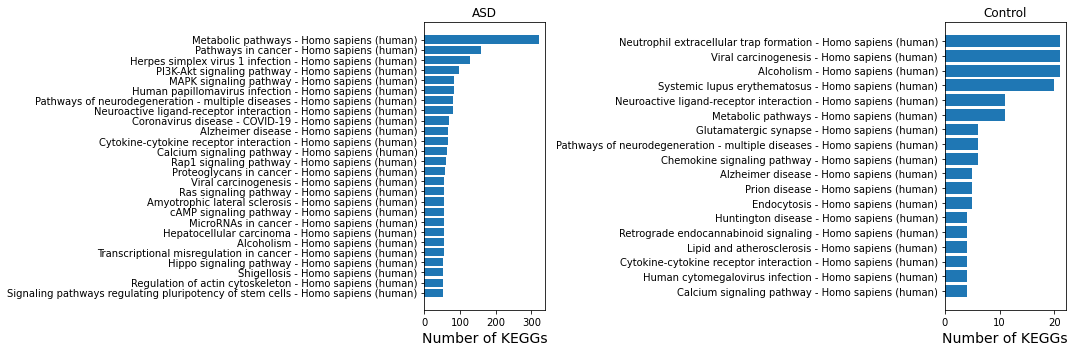

In [8]:
# Visualize KEGG counts for shotgun metagenomics data

sig_asd_rna = sig_rna.loc[sig_rna['class'] == 'ASD-associated']
sig_con_rna = sig_rna.loc[sig_rna['class'] == 'control-associated']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
pwy_counts = sig_asd_rna['Name']
pwy_counts = pwy_counts.value_counts()
pwy_counts = pwy_counts.sort_values(ascending=True)
# only focus on highly representive pathways
pwy_counts = pwy_counts.loc[pwy_counts > 50] 
ax[0].barh(pwy_counts.index, pwy_counts.values)
ax[0].set_xlabel('Number of KEGGs', fontsize=14)
ax[0].set_title('ASD')

pwy_counts = sig_con_rna['Name']
pwy_counts = pwy_counts.value_counts()
pwy_counts = pwy_counts.sort_values(ascending=True)
# only focus on highly representive pathways
pwy_counts = pwy_counts.loc[pwy_counts > 3] 
ax[1].barh(pwy_counts.index, pwy_counts.values)
ax[1].set_xlabel('Number of KEGGs', fontsize=14)
ax[1].set_title('Control')

plt.tight_layout()

The number of hits was substantially lower when compared with the 16S amplicon and shotgun data

## Overlap across omics layers

We can investigate many common metabolic genes were identified across omics levels.

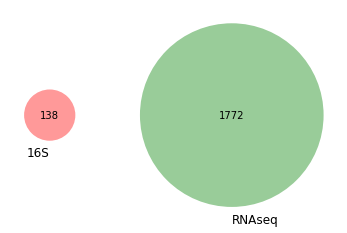

In [9]:
# Venn diagram to visualize overlap
venn2([set(sig_wgs['KEGG']), 
       set(sig_rna['KEGG'])], 
      set_labels=['16S', 'RNAseq'])

As shown here, the metabolic genes identified by 16S have a signicant overlap with those identified by shotgun metagenomics. This wasn't entirely surprising since we were restricting our attention to KEGG; furthermore 16S has a larger sequencing depth than shotgun metagenomics. However, the level of convergence among the twelve 16S and shotgun datasets analyzed here is remarkable given the low level of overlap among microbiome studies that has been previously reported in the literature.

Interestingly, there is also a strong overlap with RNAseq data, even though human genes are typically annotated differently from microbial genes. To move closer to identifying  any potential cross-talk between microbial and human genes, we decided we needed to move away from KEGG annotations and down to the compound level. This analysis would help shed light on potential interactions between both metabolic networks.

# Save compounds

In [10]:
pwy2compound = read_kegg_dict(f'{kegg_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_wgs = pd.merge(sig_wgs, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_wgs.to_csv('../results/WGS_compounds.csv')

pwy2compound = read_kegg_dict(f'{hsa_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_rna = pd.merge(sig_rna, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_rna.to_csv('../results/RNA_compounds.csv')

In [11]:
sig_wgs.to_csv('../results/supplemental_tables/Table_S11.csv')
sig_rna.to_csv('../results/supplemental_tables/Table_S12.csv')